In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (54, 829, 517)


(62, (829, 517, 62))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=42
n_lookforward=1

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
ondate_cols=[ u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364',u'TMAX', u'TMIN', u'TAVG', u'PRCP', u'holiday',
            'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2',
       'weekday1', 'weekday0']
#ondate_cols=[ u'PRCP']
#ondate_cols=columns
ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
ondate_train_test=normalize(ondate_train_test)
ondate_train_test.shape

(15,) 0.0676983 123.876


(829, 517, 15)

In [12]:
lag_cols=columns

lag_cols=array([u'visitors', u'geo1_visitors_mean', u'geo2_visitors_mean',
       u'station_visitors_mean', u'genre_name_visitors_mean',
       u'day_of_week_visitors_mean', u'visitor_lag7', u'visitor_lag14',
       u'visitor_lag28', u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364', u'visitor_ma2', u'visitor_ma4', u'visitor_ma7',
       u'visitor_ma14', u'visitor_ma28', u'visitor_ma56', u'visitor_ma112',
       u'visitor_ma224', u'visitor_sma1', u'visitor_sma2', u'visitor_sma3',
       u'visitor_sma4', u'visitor_sma8', u'visitor_sma16',
       u'visitor_sma32']        \
#                + \
#         ['visitors_minus_ma28', 'visitors_divid_ma28'] +\
#         ['all_count_y1','geo1_count_y1','station_count_y1','geo2_count_y1'] +\
#         ['all_count_y2','geo1_count_y2','station_count_y2','geo2_count_y2'] +\
#         ['all_count_y3','geo1_count_y3','station_count_y3','geo2_count_y3'] +\
#         ['all_count_y4','geo1_count_y4','station_count_y4','geo2_count_y4'] +\
#         ['all_count_y5','geo1_count_y5','station_count_y5','geo2_count_y5'] \
              )
#lag_cols=['holiday']
lag_train_test=data[:,:,get_index(lag_cols)].copy()
lag_train_test=normalize(lag_train_test)
lag_train_test.shape

(27,) 2.78577 3.02795


(829, 517, 27)

In [13]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [14]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [15]:
print K.floatx()

float32


In [16]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [32]:
batchsize=128
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*7, batchsize=batchsize,valid_split=0.1,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
valid_gen=None
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*7,478, batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)

rand split across time
train has 319288 records out of 354812 records
valid has 35524 records out of 354812 records
train has 5803 records out of 5803 records
no valid set


In [33]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2494
0


In [39]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [40]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 15, (1, 15))

In [41]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [42]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [43]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200, use_output_exp=True,use_dropout=True,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [44]:
#a.model.summary()
a.model.count_params()

459011

In [45]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2494/2494 [==============================] - 51s 20ms/step - loss: 0.3481 - total_loss: 0.3481 - reg_loss: 0.3481 - val_loss: 0.2717 - val_total_loss: 0.2717 - val_reg_loss: 0.2717
Epoch 2/200
2494/2494 [==============================] - 50s 20ms/step - loss: 0.2951 - total_loss: 0.2951 - reg_loss: 0.2951 - val_loss: 0.2551 - val_total_loss: 0.2551 - val_reg_loss: 0.2551
Epoch 3/200
2494/2494 [==============================] - 50s 20ms/step - loss: 0.2852 - total_loss: 0.2852 - reg_loss: 0.2852 - val_loss: 0.2518 - val_total_loss: 0.2518 - val_reg_loss: 0.2518
Epoch 4/200
2494/2494 [==============================] - 51s 20ms/step - loss: 0.2789 - total_loss: 0.2789 - reg_loss: 0.2789 - val_loss: 0.2482 - val_total_loss: 0.2482 - val_reg_loss: 0.2482
Epoch 5/200
2494/2494 [==============================] - 50s 20ms/step - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723 - val_loss: 0.2430 - val_total_loss: 0.2430 - val_reg_loss: 0.2430
Epoch 6/200
2494/2494 [============

<rrvf_model.KerasModel instance at 0x7fa04312b0e0>

In [46]:
a.traingen=train_gen

In [26]:
a.eval_valid()

best_epochs [7, 8, 9, 5, 6]
0.283122673912 0.283122673912
(1, 0.28312267391241103)


In [47]:
yy_pred=a.predict(300)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [9, 10, 7, 6, 5]
(829, 1) 2.64127836402 (829,)
0.234976120441 0.234976120441
(1, 0.23497612044084373)


In [28]:
traindata=train_gen.get_train()

In [51]:
def predict_train(self):
    X, y, mask,w = self.traingen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [52]:
def predict_test(self):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [30]:
gc.collect()

0

In [133]:
result=predict_train(a)

best_epochs [1, 2, 3, 4, 5]
(319288, 1) 2.7377427655 (319288, 2)


In [134]:
result[4].keys()

['masky', 'ondatex', 'lagx']

In [135]:
result[4]['lagx'].shape

(319288, 42, 27)

In [136]:
df=pd.DataFrame({'y':result[2][:,0]})

In [137]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [138]:
df=df.loc[df['y']>0]

In [139]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [140]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [147]:
import seaborn as sns; sns.set(color_codes=True)

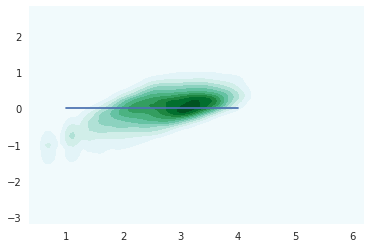

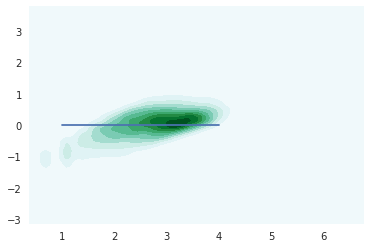

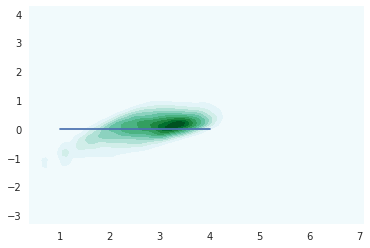

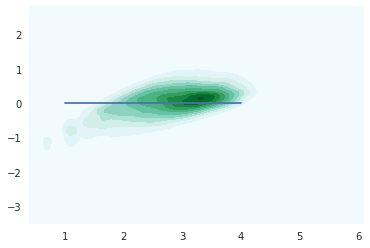

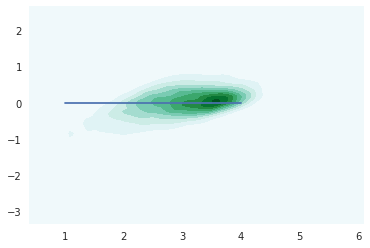

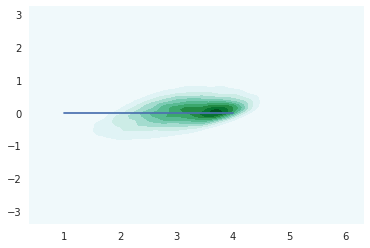

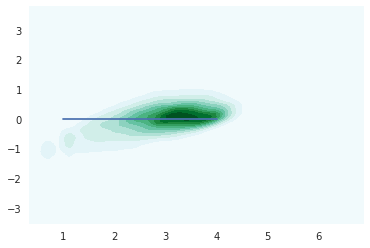

In [160]:
for i in range(1,8):
    plt.plot(np.arange(1,5),np.arange(1,5)*0)
    sns.kdeplot(df['y'][df['day']==i].values,df['error'][df['day']==i].values, shade=True)
    plt.show()

In [272]:
data1=data[(data['visitors']<4) & ( data['visitors']>=3)]

1


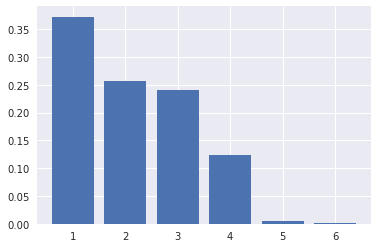

2


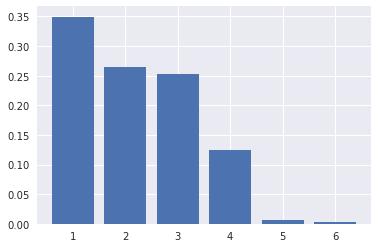

3


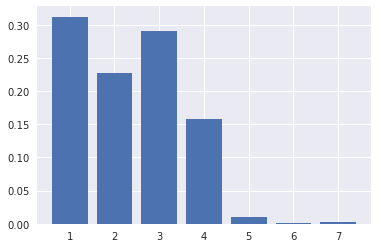

4


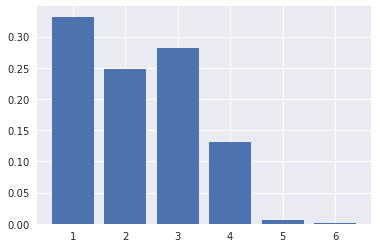

5


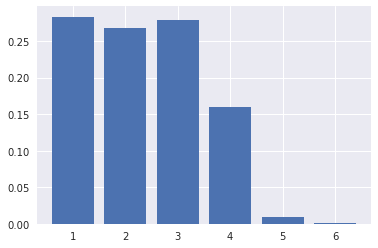

6


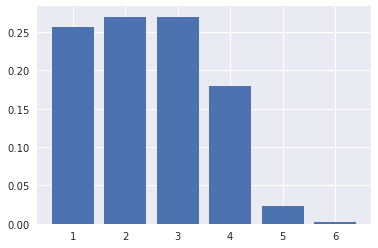

7


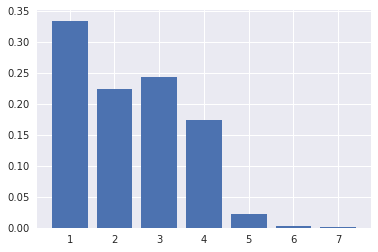

In [171]:
df['tmp']=np.round(df['y'])
for i in range(1,8):
    print i
    s=df[['tmp','error2']][df['day']==i].groupby('tmp').sum().iloc[:,0]
    plt.bar(s.index,s.values/s.sum())
    plt.show()

In [178]:
np.expm1(2)

6.3890560989306504

In [194]:
import fastparquet
data=fastparquet.ParquetFile('../input/train_test.parq').to_pandas()
#data=data[~data['visitors'].isnull()]
data1=data[data['visitors']<2]

In [195]:
data.shape,data1.shape

((428593, 29), (42873, 29))

In [229]:
data.columns

Index([u'air_store_id', u'visit_date', u'visitors', u'geo1',
       u'geo1_store_count', u'geo1_visitors_count', u'geo1_visitors_mean',
       u'geo2', u'geo2_store_count', u'geo2_visitors_count',
       u'geo2_visitors_mean', u'station', u'station_store_count',
       u'station_visitors_count', u'station_visitors_mean', u'genre_name',
       u'genre_name_store_count', u'genre_name_visitors_count',
       u'genre_name_visitors_mean', u'TMAX', u'TMIN', u'TAVG', u'PRCP',
       u'day_of_week', u'day_of_week_store_count',
       u'day_of_week_visitors_count', u'day_of_week_visitors_mean', u'holiday',
       u'is_rain'],
      dtype='object')

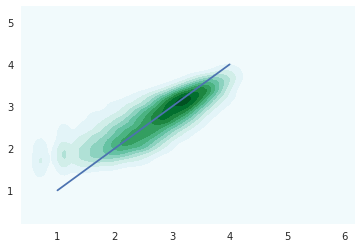

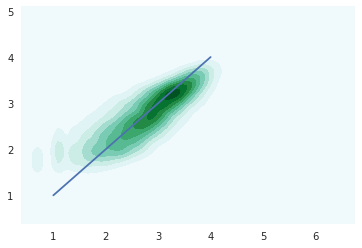

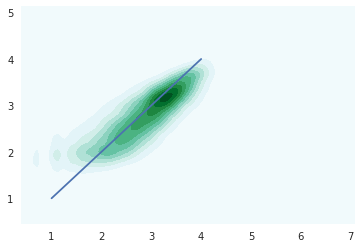

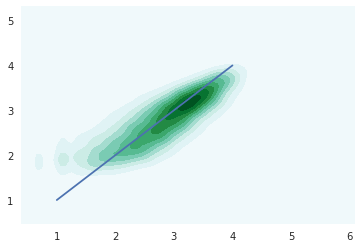

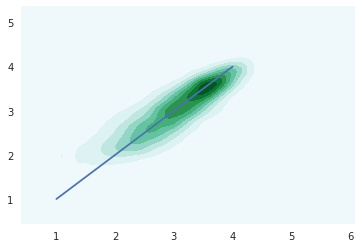

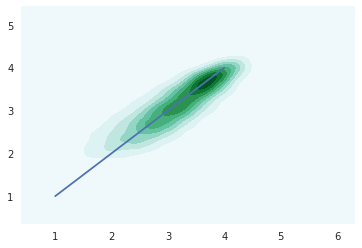

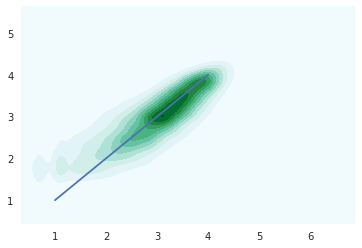

In [154]:
for i in range(1,8):
    plt.plot(np.arange(1,5),np.arange(1,5))
    sns.kdeplot(df['y'][df['day']==i].values,df['pred'][df['day']==i].values, shade=True)
    plt.show()

In [150]:
gc.collect()

322

In [141]:
df2=df.groupby("dayidx").mean() 

In [142]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [103]:
df2[['day','error2']].groupby('day').median()

error2
day          
1    0.293757
2    0.271146
3    0.257979
4    0.261040
5    0.206163
6    0.219717
7    0.297302

In [108]:
rrvf_data.idx_to_date([477])

array(['2017-04-22'],
      dtype='|S10')

In [109]:
df2.tail(20)

y      pred  day     error    error2        date
dayidx                                                         
451     2.671041  2.665940    1  0.005102  0.289316  2017-03-27
452     2.771381  2.738047    2  0.033334  0.270885  2017-03-28
453     2.892507  2.832985    3  0.059522  0.228068  2017-03-29
454     2.845945  2.901065    4 -0.055121  0.246937  2017-03-30
455     2.965734  3.001873    5 -0.036139  0.231154  2017-03-31
456     3.014834  3.084962    6 -0.070128  0.239613  2017-04-01
457     2.853454  2.845879    7  0.007574  0.289653  2017-04-02
458     2.624242  2.695771    1 -0.071529  0.317882  2017-04-03
459     2.645662  2.716293    2 -0.070631  0.291709  2017-04-04
460     2.722008  2.763445    3 -0.041436  0.260083  2017-04-05
461     2.658599  2.782213    4 -0.123614  0.281604  2017-04-06
462     2.901564  2.970315    5 -0.068750  0.220734  2017-04-07
463     3.029943  3.126703    6 -0.096760  0.219574  2017-04-08
464     2.833526  2.882921    7 -0.049396  0.300944  2017-04-09
465     2.560280  2.593698    1 -0.033418  0.279954  2017-04-10
466     2.501610  2.639017    2 -0.137407  0.303426  2017-04-11
467     2.721908  2.696592    3  0.025316  0.245659  2017-04-12
468     2.713172  2.737450    4 -0.024277  0.225085  2017-04-13
469     2.986863  2.998174    5 -0.011311  0.190920  2017-04-14
470     3.129421  3.190185    6 -0.060764  0.173954  2017-04-15

1


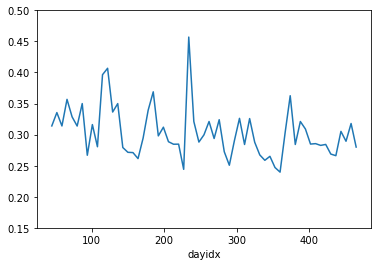

2


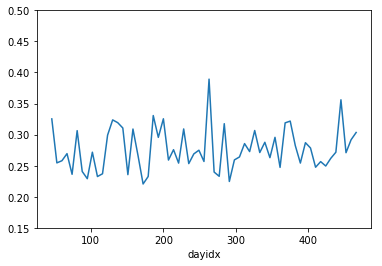

3


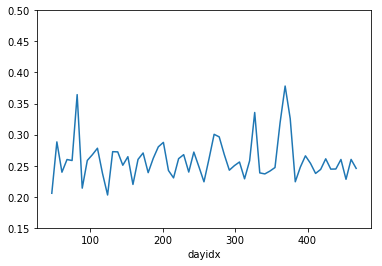

4


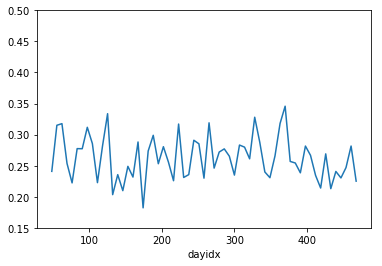

5


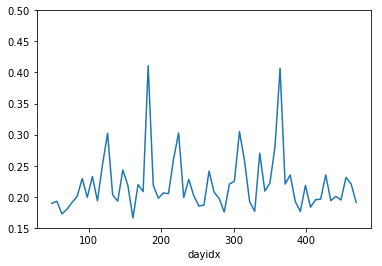

6


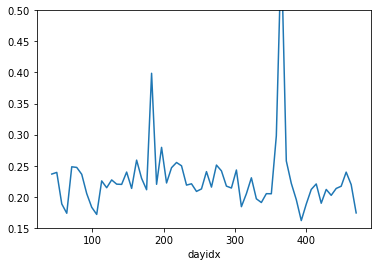

7


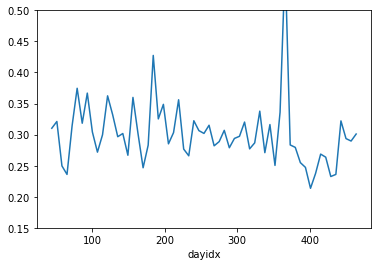

In [95]:
for i in range(1,8):
    print i
    df2[df2['day']==i]['error2'].plot();
    plt.ylim([0.15,0.5])
    plt.show()

In [120]:
df2.sort_values('error2').tail(20)

y      pred  day     error    error2        date
dayidx                                                         
219     2.795018  2.894445    7 -0.099427  0.356095  2016-08-07
66      2.580164  2.624913    1 -0.044749  0.356743  2016-03-07
156     2.824238  2.874074    7 -0.049836  0.359877  2016-06-05
121     2.984559  2.917296    7  0.067264  0.362402  2016-05-01
374     2.699086  2.779925    1 -0.080839  0.362588  2017-01-09
82      2.760136  2.804211    3 -0.044074  0.364355  2016-03-23
93      2.882839  2.924215    7 -0.041376  0.366798  2016-04-03
185     2.595939  2.620683    1 -0.024744  0.368873  2016-07-04
79      3.092327  2.978220    7  0.114107  0.374578  2016-03-20
369     2.730056  2.792283    3 -0.062226  0.378174  2017-01-04
263     2.386368  2.614037    2 -0.227668  0.389294  2016-09-20
115     2.622873  2.702134    1 -0.079260  0.396446  2016-04-25
183     3.066671  3.077862    6 -0.011191  0.398710  2016-07-02
364     3.051710  3.066795    5 -0.015085  0.406708  2016-12-30
122     2.939930  2.703708    1  0.236223  0.406785  2016-05-02
182     3.010957  2.944709    5  0.066248  0.410833  2016-07-01
184     2.871325  2.863994    7  0.007331  0.427455  2016-07-03
234     2.372722  2.581493    1 -0.208771  0.457002  2016-08-22
366     2.718705  2.814717    7 -0.096012  0.575928  2017-01-01
365     2.660961  2.886856    6 -0.225895  0.599919  2016-12-31

In [101]:
holiday=pd.read_csv('../input/date_info.csv')
holiday=holiday[holiday['holiday_flg']==1]

In [59]:
import rrvf_data

In [53]:
result=predict_test(a)

best_epochs [9, 10, 7, 6, 5]
(5803, 1) 2.70816835872 (5803, 2)


In [54]:
df=pd.DataFrame({'y':result[2][:,0]})

In [55]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [56]:
df=df.loc[df['y']>0]

In [57]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [60]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [61]:
df2=df.groupby("dayidx").mean() 

In [62]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [63]:
df2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904966  0.024144  0.260231    7  2017-04-16
472     2.507290  2.583298 -0.076008  0.250163    1  2017-04-17
473     2.661330  2.598076  0.063254  0.274913    2  2017-04-18
474     2.754815  2.713841  0.040974  0.230694    3  2017-04-19
475     2.713762  2.687622  0.026140  0.261172    4  2017-04-20
476     2.999000  2.927730  0.071270  0.172499    5  2017-04-21
477     3.075529  3.110956 -0.035427  0.203173    6  2017-04-22

# time split

In [32]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*4, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
valid_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*4,478-n_lookforward*2, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

train has 357299 records out of 357299 records
no valid set
train has 1658 records out of 1658 records
no valid set
train has 829 records out of 829 records
no valid set


In [33]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2791
12


In [34]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [35]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 8, (1, 8))

In [36]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [37]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [38]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [39]:
#a.model.summary()
print gc.collect()
a.model.count_params()

454


455425

In [40]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 2.5995 - val_loss: 0.2717 - val_total_loss: 0.2717 - val_reg_loss: 0.9499
Epoch 2/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2837 - total_loss: 0.2837 - reg_loss: 2.5131 - val_loss: 0.2499 - val_total_loss: 0.2499 - val_reg_loss: 0.8878
Epoch 3/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 2.4670 - val_loss: 0.2563 - val_total_loss: 0.2563 - val_reg_loss: 0.8219
Epoch 4/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 2.4382 - val_loss: 0.2747 - val_total_loss: 0.2747 - val_reg_loss: 0.8155
Epoch 5/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 2.3925 - val_loss: 0.2606 - val_total_loss: 0.2606 - val_reg_loss: 0.8171


<rrvf_model.KerasModel instance at 0x7f7e885d5d88>

In [41]:
#a.traingen=train_gen

In [42]:
a.eval_valid()

best_epochs [2, 3, 5, 1, 4]
0.258842468217 0.258842468217
(1, 0.25884246821678769)


In [43]:
yy_pred=a.predict(400)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.02983174963 (829,)


In [44]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.190820011306 0.190820011306
(1, 0.19082001130563031)


In [49]:
n_lookforward

1

In [50]:
yy_pred=a.predict(478-n_lookforward-1)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.87643025494 (829,)
0.182698888629 0.182698888629
(1, 0.18269888862869477)


In [51]:
yy_pred=a.predict(478-n_lookforward-2)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.62079328142 (829,)
0.270138534272 0.270138534272
(1, 0.27013853427158546)


In [52]:
yy_pred=a.predict(478-n_lookforward-3)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.60231247107 (829,)
0.243763329538 0.243763329538
(1, 0.24376332953775123)


In [53]:
yy_pred=a.predict(478-n_lookforward-4)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.52984273246 (829,)
0.278246599289 0.278246599289
(1, 0.27824659928872975)


In [45]:
yy_pred=a.predict(478-n_lookforward)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.06015446194 (829,)


In [46]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.209365883356 0.209365883356
(1, 0.20936588335586601)
